# AIDI 1011 - Semester Project

**Project Title:**<br>
AI Applied to Health Sector: Using X-Ray Images to Predict Thorax Disease



# Importing Libraries

In [ ]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import pathlib
import warnings
import os, random, time, gc, glob
from IPython.display import Markdown, display
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from datetime import datetime
from itertools import chain

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Image Classification
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [ ]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Acquisition

In [ ]:
# This dataset contains auxiliar data that will be important to better classify the images
df_aux = pd.read_csv('/content/drive/MyDrive/Georgian College/AIDI 1011/Auxiliar_Data.csv', sep=",")
df_aux = df_aux[[
    'Image Index',
    'Follow-up #',
    'Patient Age',
    'Patient Gender',
    'View Position',
    'Finding Labels'
]]

df_aux.rename(columns={
    'Image Index'       : "filename",
    'Finding Labels'    : "label",
    'Follow-up #'       : "followup",
    'Patient Age'       : "age",
    'Patient Gender'    : "gender",
    'View Position'     : "view"
}, inplace = True)

df_aux.tail()

,filename,followup,age,gender,view,label
112115,00030801_001.png,1,38,M,PA,Mass|Pneumonia
112116,00030802_000.png,0,28,M,PA,No Finding
112117,00030803_000.png,0,42,F,PA,No Finding
112118,00030804_000.png,0,29,F,PA,No Finding
112119,00030805_000.png,0,26,M,PA,No Finding


In [ ]:
# Train and test folders
train_dir   = "/content/drive/MyDrive/Georgian College/AIDI 1011/data/train"
test_dir    = "/content/drive/MyDrive/Georgian College/AIDI 1011/data/test"

In [ ]:
# Expand all subfolders inside each folder,
# and store the directory path and name of the folder in a tuple (path, foldername)
def load_subfolders(subdir):
    dir = []
    for file in os.listdir(subdir):
        d = os.path.join(subdir, file)
        if os.path.isdir(d):
            #print(d)
            dir.append((d, d.split("/")[-1]))

    return dir

train_subdir = load_subfolders(train_dir)
print(train_subdir)
test_subdir = load_subfolders(test_dir)
print(test_subdir)

[('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Atelectasis', 'Atelectasis'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Infiltration', 'Infiltration'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Effusion', 'Effusion'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/No Findings', 'No Findings'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Mass', 'Mass'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Cardiomegaly', 'Cardiomegaly'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Edma', 'Edma'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Emphysema', 'Emphysema'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/train/Pneumothorax', 'Pneumothorax')]
[('/content/drive/MyDrive/Georgian College/AIDI 1011/data/test/Cardiomegaly', 'Cardiomegaly'), ('/content/drive/MyDrive/Georgian College/AIDI 1011/data/test/Effusion', 'Effusion'), ('/content/dr

In [ ]:
# Open a directory and store the image path and names in a dataframe

def load_images(subdir):
    image_data = []
    for dir, label in subdir:
        for image_path in glob.glob(os.path.join(dir, "*.png")):
            image_data.append({"filename":image_path.split("/")[-1], "label": label, "path": image_path })
            #image_data.append({"filename":image_path.split("/")[-1], "path": image_path })

    df = pd.DataFrame(image_data)
    return df

## Creating a Train Dataset

In [ ]:
# Load images for Training subfolders into a dataframe called "df_train"

df_train = load_images(train_subdir)
print("The train dataset contains",df_train.shape[0],"images")
display(df_train)

The train dataset contains 7538 images


,filename,label,path
0,00000030_001.png,Atelectasis,/content/drive/MyDrive/Georgian College/AIDI 1...
1,00000030_000.png,Atelectasis,/content/drive/MyDrive/Georgian College/AIDI 1...
2,00000011_006.png,Atelectasis,/content/drive/MyDrive/Georgian College/AIDI 1...
3,00000060_000.png,Atelectasis,/content/drive/MyDrive/Georgian College/AIDI 1...
4,00000047_004.png,Atelectasis,/content/drive/MyDrive/Georgian College/AIDI 1...
...,...,...,...
7533,00014014_012.png,Pneumothorax,/content/drive/MyDrive/Georgian College/AIDI 1...
7534,00014032_013.png,Pneumothorax,/content/drive/MyDrive/Georgian College/AIDI 1...
7535,00014032_015.png,Pneumothorax,/content/drive/MyDrive/Georgian College/AIDI 1...
7536,00014083_019.png,Pneumothorax,/content/drive/MyDrive/Georgian College/AIDI 1...


In [ ]:
#Add auxiliar data to our train dataset
#df_train = pd.merge(df_train, df_aux, on='filename', how='left')
#df_train

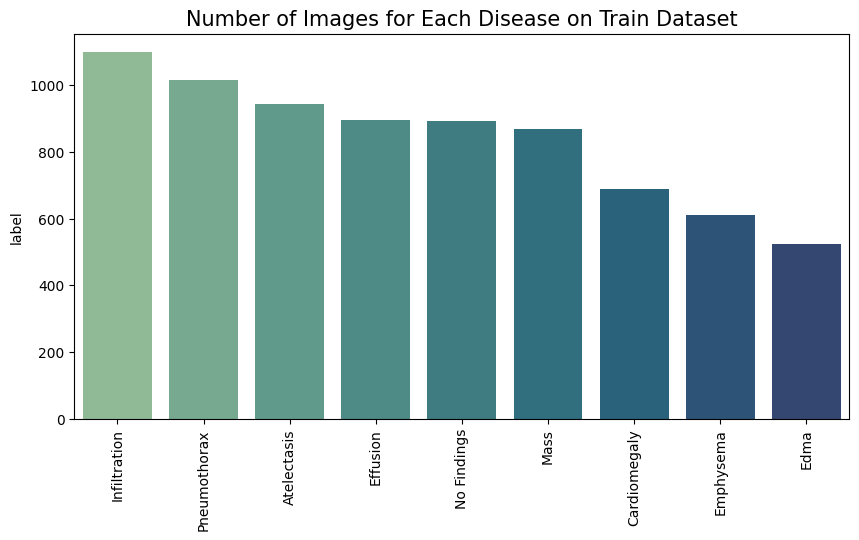

In [ ]:
# Plot that display number of images

fc = df_train["label"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of Images for Each Disease on Train Dataset", fontsize = 15)
plt.xticks(rotation=90)
plt.show()


**Shuffling data** serves the purpose of reducing variance and making sure that models remain general and overfit less.

In [ ]:
#Shuffle rows

df_train = df_train.sample(frac=1).reset_index(drop=True)

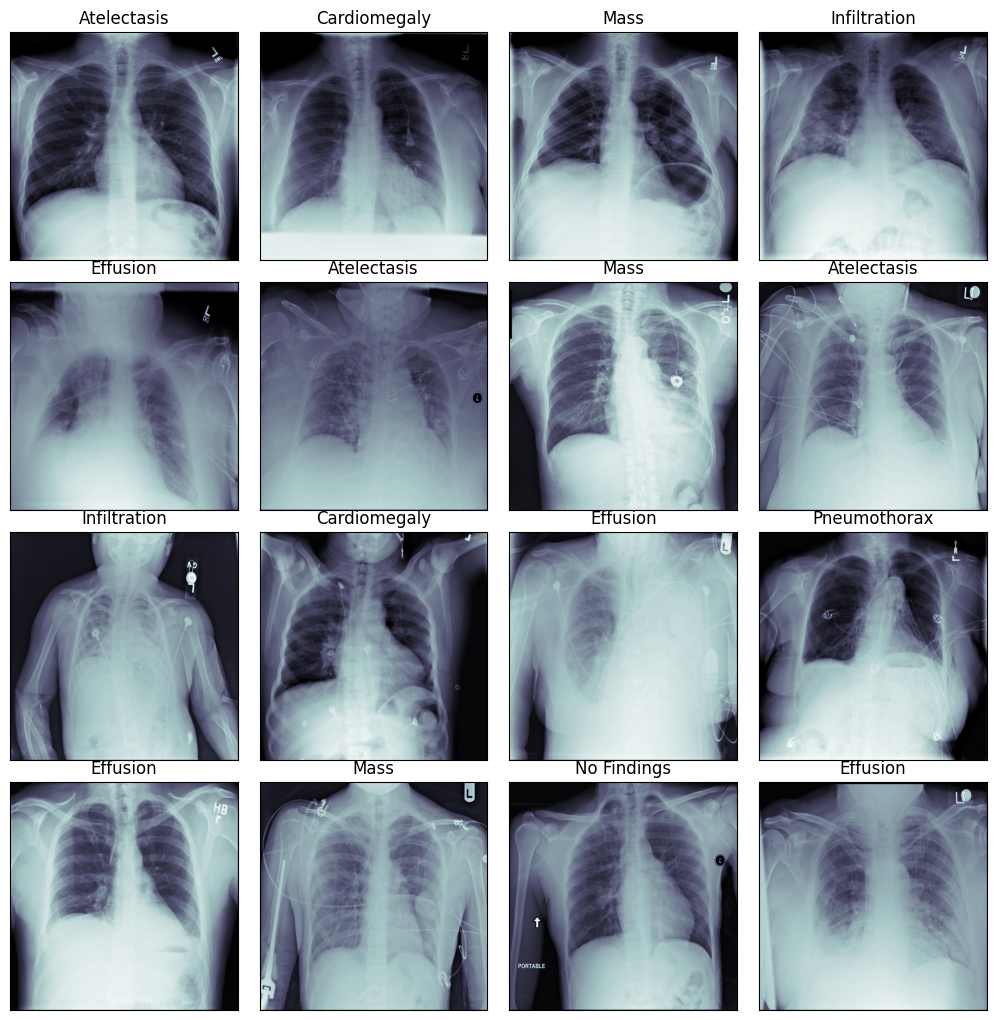

In [ ]:
#Display some images on our train dataset

fig, axes = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_train.path[i+20]), cmap = 'bone')
    ax.set_title(df_train.label[i+20], fontsize = 12)

plt.tight_layout(pad=0.0)
plt.show()

## Creating a Test Dataset

In [ ]:
# Load images for Testing subfolders into a dataframe called "df_test"

df_test = load_images(test_subdir)
print("The train dataset contains",df_test.shape[0],"images")
display(df_test)

The train dataset contains 961 images


,filename,label,path
0,00000032_056.png,Cardiomegaly,/content/drive/MyDrive/Georgian College/AIDI 1...
1,00004893_046.png,Cardiomegaly,/content/drive/MyDrive/Georgian College/AIDI 1...
2,00004630_001.png,Cardiomegaly,/content/drive/MyDrive/Georgian College/AIDI 1...
3,00008365_000.png,Cardiomegaly,/content/drive/MyDrive/Georgian College/AIDI 1...
4,00005066_008.png,Cardiomegaly,/content/drive/MyDrive/Georgian College/AIDI 1...
...,...,...,...
956,00003914_000.png,No Findings,/content/drive/MyDrive/Georgian College/AIDI 1...
957,00003914_003.png,No Findings,/content/drive/MyDrive/Georgian College/AIDI 1...
958,00003921_001.png,No Findings,/content/drive/MyDrive/Georgian College/AIDI 1...
959,00003923_001.png,No Findings,/content/drive/MyDrive/Georgian College/AIDI 1...


In [ ]:
#Add auxiliar data to our test dataset
#df_test = pd.merge(df_test, df_aux, on='filename', how='left')
#df_test

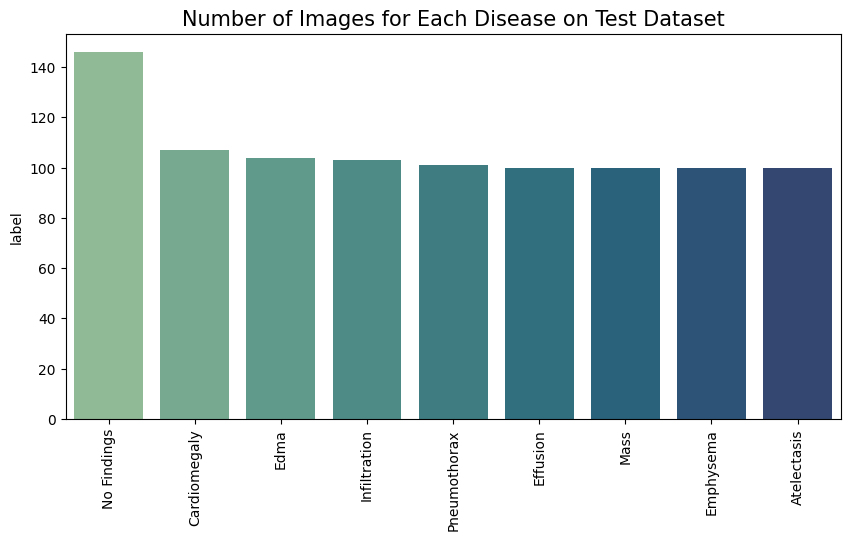

In [ ]:
# Plot that display number of images

fc = df_test["label"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of Images for Each Disease on Test Dataset", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Shuffle rows

df_test = df_test.sample(frac=1).reset_index(drop=True)

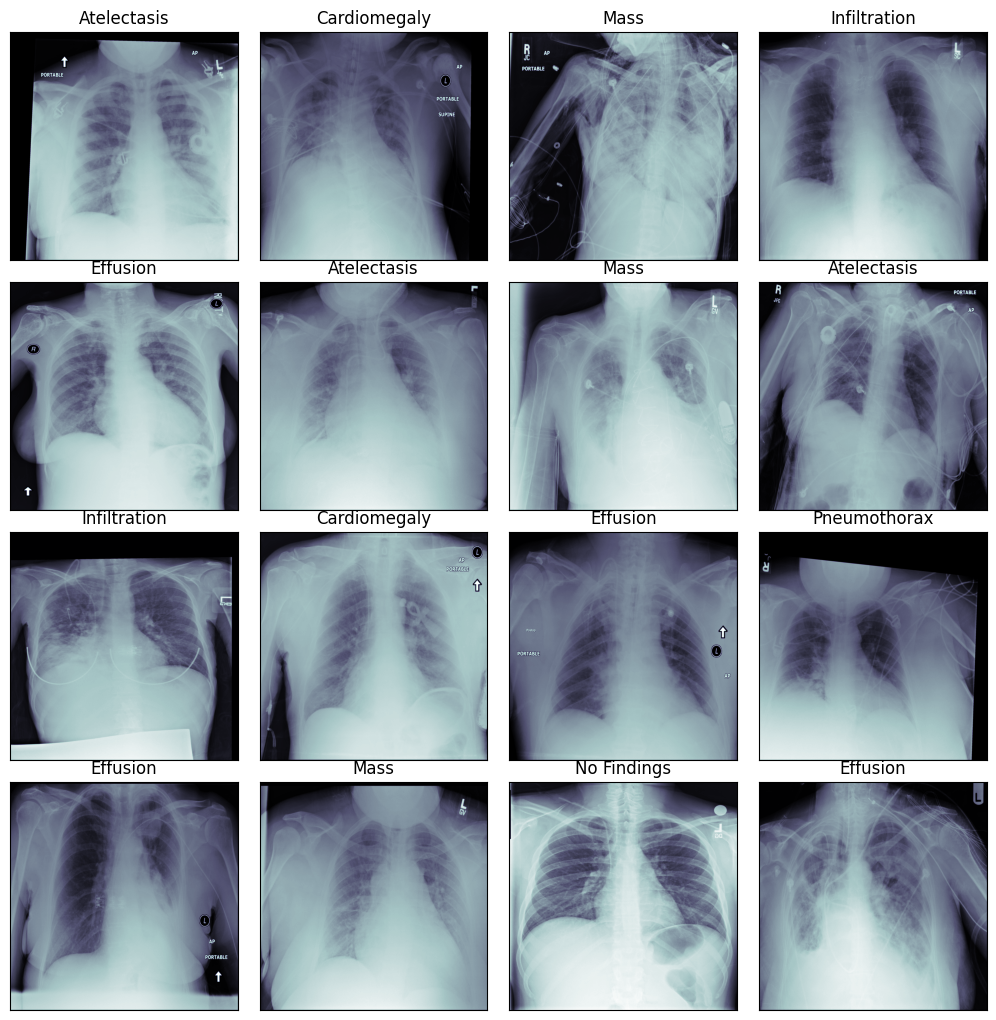

In [ ]:
#Display some images on our test dataset

fig, axes = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.path[i+20]), cmap = 'bone')
    ax.set_title(df_train.label[i+20], fontsize = 12)

plt.tight_layout(pad=0.0)
plt.show()

# Data Preprocessing

In [ ]:
try:
    print("Loading from drive...",datetime.now().strftime("%H:%M:%S"))
    X_train = np.load('/content/drive/MyDrive/Georgian College/AIDI 1011/X_train_preprocessed.npy')
    X_test  = np.load('/content/drive/MyDrive/Georgian College/AIDI 1011/X_test_preprocessed.npy')
    loaded = 1
    print("Loaded!",datetime.now().strftime("%H:%M:%S"))
except:
    loaded = 0

Loading from drive... 21:05:14


In [ ]:
IMG_SIZE = (128, 128)

def preprocess_images(df):

    # Create an array to store the preprocessed images
    X_aux = []

    for i in range(len(df)):
        # Read the image
        img = cv2.imread(df.iloc[i]['path'])

        # Resize the image to a uniform size
        img = cv2.resize(img, IMG_SIZE)

        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize the pixel values
        img = img / 255

        # Add the preprocessed image to the X_aux array
        X_aux.append(img)

    return X_aux

In [ ]:
if loaded == 0:
    print("Start Time:", datetime.now().strftime("%H:%M:%S"))

    X_train = preprocess_images(df_train)
    X_test = preprocess_images(df_test)

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    print("End Time:", datetime.now().strftime("%H:%M:%S"))

else: pass

Start Time: 21:05:14
End Time: 22:04:51


In [ ]:
if loaded == 1: pass
else:
    # Export: Save the pre-processed image arrays to a file
    np.save('/content/drive/MyDrive/Georgian College/AIDI 1011/X_train_preprocessed.npy', X_train)
    np.save('/content/drive/MyDrive/Georgian College/AIDI 1011/X_test_preprocessed.npy', X_test)

In [ ]:
# Reshape the arrays to add an extra channel dimension
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)


In [ ]:
y_train = df_train['label']
y_test  = df_test['label']

Currently, we have **4** dimension in our input data:
- batch size
- channels
- height
- width


In [ ]:
print("X train:",X_train.shape)
print("X test:\t",X_test.shape)

print("y train\t",y_train.shape)
print("y test\t",y_test.shape)

X train: (7538, 128, 128, 1)
X test:	 (961, 128, 128, 1)
y train	 (7538,)
y test	 (961,)


We need to flatten out our images to only **2** dimensions:
- number of images
- channels * height * width

In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
print(X_train_reshaped.shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
print(X_test_reshaped.shape)

(7538, 16384)
(961, 16384)


# Model Training

## Sequential CNN Model

**Why:** CNNs are well-suited for image classification tasks because they can automatically learn to extract relevant features from images without the need for manual feature engineering.

**How it Works:** It apply a series of convolutional filters or kernals to the input image. Each filter scans across the image and applies a set of weights to each pixel, producing a new output pixel value that reflects the presence or absence of a particular feature at that location. This process is repeated multiple times, with each layer of the model applying a new set of filters that learn increasingly complex and abstract features.

In [ ]:
SCNN_model = Sequential([
    Conv2D(8, 3, input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(8, activation='softmax'),
])

SCNN_model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

SCNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 31752)             0         
                                                                 
 dense (Dense)               (None, 8)                 254024    
                                                                 
Total params: 254,104
Trainable params: 254,104
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Neural Networks doesn't work with categorical labels,
# so we have to encode them before training the sequencial CNN model

label_encoder = LabelEncoder()
df_train_encoded = df_train.copy()
df_train_encoded['label_encoded'] = label_encoder.fit_transform(df_train['label'])

y_train_CNN = df_train_encoded['label_encoded']
y_test_CNN  = df_train_encoded['label_encoded']

In [ ]:
history = SCNN_model.fit(
    X_train,
    to_categorical(y_train_CNN),
    epochs = 10
)

Epoch 1/10
152/152 [==============================] - 26s 159ms/step - loss: 2.0615 - accuracy: 0.2455
Epoch 2/10
152/152 [==============================] - 28s 183ms/step - loss: 1.8025 - accuracy: 0.3127
Epoch 3/10
152/152 [==============================] - 27s 176ms/step - loss: 1.7312 - accuracy: 0.3479
Epoch 4/10
152/152 [==============================] - 25s 166ms/step - loss: 1.6540 - accuracy: 0.3835
Epoch 5/10
152/152 [==============================] - 26s 170ms/step - loss: 1.5899 - accuracy: 0.4184
Epoch 6/10
152/152 [==============================] - 29s 190ms/step - loss: 1.5135 - accuracy: 0.4592
Epoch 7/10
152/152 [==============================] - 27s 175ms/step - loss: 1.4327 - accuracy: 0.5003
Epoch 8/10
152/152 [==============================] - 24s 159ms/step - loss: 1.3551 - accuracy: 0.5365
Epoch 9/10
152/152 [==============================] - 26s 172ms/step - loss: 1.2768 - accuracy: 0.5661
Epoch 10/10
152/152 [==============================] - 26s 172ms/step - l

dict_keys(['loss', 'accuracy'])


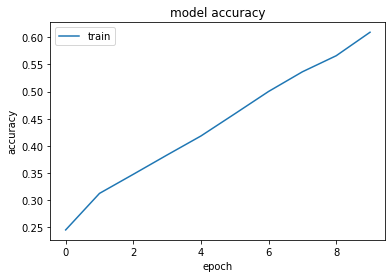

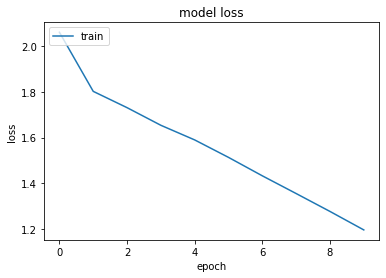

In [ ]:
# List all data in history
print(history.history.keys())

# Plot history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Random Forest

**Why:** It can handle noisy and high-dimensional data,such as images, without the risk of overfitting, which can occur with other machine learning algorithms. It even provides feature importances which can help to understand which features are most important in making classification decisions.
<br>
**How it Works:** The way a random forest works is by creating a large number of decision trees, where each tree is trained on a random subset of the data and features. During training, each decision tree in the forest learns to split the data into subsets based on the values of the features, with the goal of minimizing the impurity of the resulting subsets.

In [ ]:
#1) Create a random forest classifier
RFC_model = RandomForestClassifier(n_estimators = 100)

#2) Train the model on the reshaped training data
RFC_model.fit(X_train_reshaped, y_train)

#3) Make predictions on the reshaped test data
y_pred = RFC_model.predict(X_test_reshaped)

#4) Evaluation using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy: {:.2f}%".format(accuracy * 100))


Random Forest Classifier Accuracy: 64.17%


**Output:**
> Random Forest Classifier Accuracy: 64.17%

## SVC (Support Vector Classifier)

**Why:** SVCs can handle noisy high-dimensional data well,  such as images, without the risk of overfitting, which can occur with other machine learning algorithms. It can use different kernel functions to map the input data into a higher-dimensional space, allowing them to capture complex relationships between the input features.
<br>
**How it Works:** The way an SVC works is by finding the hyperplane that separates the data into different classes in a way that maximizes the margin between the classes. In the case of multiclass classification, SVCs can use techniques such as one-vs-one or one-vs-all to extend binary classification to multiple classes.

In [ ]:
print("Start Time:", datetime.now().strftime("%H:%M:%S"))

# Define different kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Train a SVC with each kernel function
for k in kernels:

    # Create the classifier
    SVC_model = SVC(kernel = k)

    # Train the model on the training data
    SVC_model.fit(X_train_reshaped, y_train)

    # Make predictions on the test data
    y_pred = SVC_model.predict(X_test_reshaped)

    # Evaluation using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(str(k).upper(),"Kernel Accuracy: {:.2f}%".format(accuracy * 100))

print("End Time:", datetime.now().strftime("%H:%M:%S"))


Start Time: 03:33:02
LINEAR Kernel Accuracy: 66.01%
POLY Kernel Accuracy: 64.05%
RBF Kernel Accuracy: 18.28%
SIGMOID Kernel Accuracy: 12.88%
End Time: 04:13:29


**Output:**

> LINEAR Kernel Accuracy: 66.01% <br>
> POLY Kernel Accuracy: 64.05% <br>
> RBF Kernel Accuracy: 18.28% <br>
> SIGMOID Kernel Accuracy: 12.88% <br>


## RestNet50

**Why:** It is a deep neural network architecture that can capture complex features and patterns in images.It even allows for transfer learning to be used in medical image analysis.
<br>
**How it Works:** It uses a series of convolutional layers to extract features from the input image. The network learns to identify features at different levels of abstraction, from edges and corners to more complex patterns and shapes. The output of the convolutional layers is then passed through one or more fully connected layers, which make the final classification decision.

In [ ]:
# Define the image size and number of classes
img_height = 128
img_width = 128
num_classes = 8

# Define the batch size and number of epochs
batch_size = 32
epochs = 10

In [ ]:

# Define the data generators with image augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the data generator without augmentation for the validation data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4835 images belonging to 8 classes.
Found 815 images belonging to 8 classes.


In [ ]:
# Load the pre-trained ResNet50 model and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


94765736/94765736 [==============================] - 2s 0us/step


In [ ]:

# Add a global average pooling layer and a dense output layer for the number of classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the full model with the pre-trained base and new output layers
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:

# Freeze the base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)


Epoch 1/10
152/152 [==============================] - 1253s 8s/step - loss: 1.9851 - accuracy: 0.2155 - val_loss: 2.2612 - val_accuracy: 0.1227
Epoch 2/10
152/152 [==============================] - 495s 3s/step - loss: 1.9618 - accuracy: 0.2143 - val_loss: 2.3728 - val_accuracy: 0.1227
Epoch 3/10
152/152 [==============================] - 484s 3s/step - loss: 1.9542 - accuracy: 0.2217 - val_loss: 2.2749 - val_accuracy: 0.1215
Epoch 4/10
152/152 [==============================] - 484s 3s/step - loss: 1.9414 - accuracy: 0.2186 - val_loss: 2.2375 - val_accuracy: 0.1264
Epoch 5/10
152/152 [==============================] - 488s 3s/step - loss: 1.9370 - accuracy: 0.2145 - val_loss: 2.2606 - val_accuracy: 0.1264
Epoch 6/10
152/152 [==============================] - 491s 3s/step - loss: 1.9359 - accuracy: 0.2238 - val_loss: 2.2563 - val_accuracy: 0.1264
Epoch 7/10
152/152 [==============================] - 473s 3s/step - loss: 1.9358 - accuracy: 0.2217 - val_loss: 2.2520 - val_accuracy: 0.126

Epoch 1/10: accuracy: 0.2070
<br>
Epoch 10/10: accuracy: 0.2252

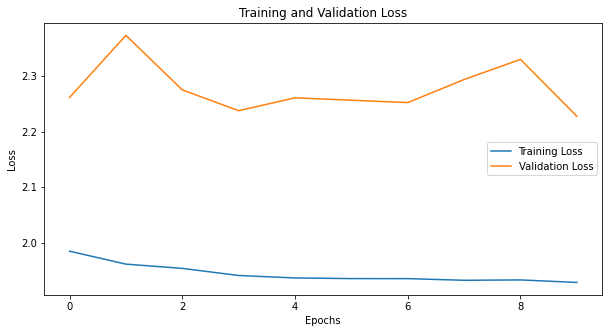

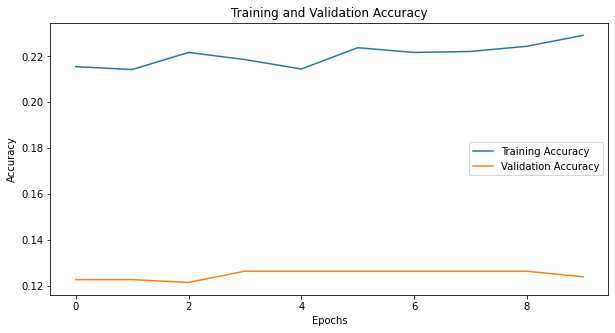

In [ ]:
# Evaluate the model

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## XGBOOST (using VGG16)

**Why:** It can be trained on a dataset of chest-xray images that are labeled with the corresponding disease. During training, VGG16 will learn to extract useful features from the images that are associated with each disease. These features are then used to classify new, unseen images.
<br>
**How it Works:** It works by passing the input image through a series of convolutional layers, which extract features from the image at multiple scales. These features are then passed through a series of fully connected layers, which perform the actual classification. The output of the last layer is a probability distribution over the different disease classes, indicating the likelihood that the input image belongs to each class.

### Using VGG16 to extract features

To use a XGBoost model for image classification, we first need to convert our image data into a feature matrix.

Let's use a pre-trained CNN (VGG16) to extract the features from the images, and then use these features as inputs to XGBoost.


In [ ]:
# Load VGG16 model (without top layers)
vgg_model = VGG16(include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128, 128),
                                                  batch_size=32,
                                                  class_mode='categorical')


Found 5626 images belonging to 9 classes.
Found 961 images belonging to 9 classes.


In [ ]:
# Extract features using VGG16 model
train_features = vgg_model.predict(train_generator, steps=train_generator.samples/train_generator.batch_size, verbose=1)
test_features = vgg_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)


30/30 [==============================] - 145s 5s/step


In [ ]:
# Save features and labels as NumPy arrays
np.save('train_features.npy', train_features)
np.save('test_features.npy', test_features)
np.save('train_labels.npy', train_generator.classes)
np.save('test_labels.npy', test_generator.classes)

In [ ]:
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

### Using the features to build the actual XGBoost Model

In [ ]:
train_data = train_features.reshape(train_features.shape[0], -1)

In [ ]:
print(train_data)

[[ 0.         0.         0.        ...  0.        22.862299   0.       ]
 [ 1.2343026  0.         0.        ...  0.         6.071487   2.1134374]
 [ 0.         0.         0.        ...  0.         1.0438483  0.       ]
 ...
 [ 0.         0.         0.        ...  0.         4.2931848  0.       ]
 [ 0.         0.         0.        ...  2.6173918 28.79067    0.       ]
 [ 0.         0.         0.        ...  0.         2.7262423  0.       ]]


In [ ]:
# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax')
xgb_model.fit(train_data, train_labels)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [ ]:
test_data = test_features.reshape(test_features.shape[0], -1)

In [ ]:
  # Evaluate model on test set
acc = xgb_model.score(test_data, test_labels)
print("Accuracy on test set: {:.2f}%".format(acc * 100))

Accuracy on test set: 9.89%


# Model Selection

In order to pick the correct model among the ones trained for this final stage of the project, first we need to compare the **accuracy** of each one:
- CNN: 60.93%
- Random Forest: 64.17%
- SVC
> LINEAR Kernel: 66.01% <br>
> POLY Kernel: 64.05% <br>
> RBF Kernel: 18.28% <br>
> SIGMOID Kernel: 12.88% <br>
- RestNet50: 22.92
- XGBoost: 9.89%

**The top 3 models are: SVC Linear Kernel, SVC Poly Kernel, RF, CNN**

<br><br>
Also, we need to consider the complexity of each model. Models that are too complex can be prone to overfitting, meaning that they perform well on the training set but poorly on the validation or test set. On the other hand, models that are too simple may not be able to capture the complexity of the underlying patterns in your data.

**Easiest models to train and understand: RF, CNN, SVC Linear Kernel**

<br><br>
Finally, the computational requirements of each model must also be considered. Some models may be more computationally intensive than others, which can make them slower and more difficult to work with. You want to choose a model that is computationally feasible for your resources and time constraints.
**Best models regarding to computational requirements and efficiency: CNN, RF**

<br><br>
Based on these factors, the group has decided to move forward with the CNN model even though it didn't have the highest accuracy, but due to a few othe reasons:
- A Random Forest is easy to understand and has been explored already too many times in previous works for this task. We wanted to step forward in image classification and challenge ourselves with neural network algorithms
- There are multiple CNN algorithms available, which make it very interesting for us to use break-through technology to better predict diseases.

## **Winner: CNN**

## Choosing the right improvement technique

there are many different approaches and algorithms we can try for training CNNs beyond the sequential model:

- Skip Connections
- Residual
- Dense
- Recurrent
- Keras

From the options listed above, **Keras** provides a user-friendly and intuitive interface for building, training, and evaluating neural networks. It also has many built-in utilities for data preprocessing, data augmentation, and model visualization.

# Final Solution: MobileNet Model

As we are working with a resource-constrained environment and we need a fast, efficient model that can achieve good accuracy on image classification tasks, MobileNet is our model of choice.

**What is the MobileNet model?** <br>
It is a CNN architecture designed for vision applications. It was introduced by Google in 2017 as a lightweight, low-latency model that could be run efficiently on devices with limited processing power and memory.

**Reasons:**

- Efficiency: It is a lightweight model with fewer parameters and computations than many other CNN models.
- Speed: It can be trained and evaluated faster than larger models. This can be particularly useful when working with large datasets or limited computing resources (Google Colab).
- Accuracy: Despite its smaller size and computational efficiency, MobileNet can still achieve good accuracy on image classification tasks, particularly when combined with techniques like transfer learning.
- Pre-trained weights: MobileNet has pre-trained weights available that can be used for transfer learning, which can help speed up the training process and improve the accuracy of the model.

## 1) Prepare the Data

The first step to train a CNN model with MobileNet for our image classification of x-ray chest diseases is to prepare the data for the training process.

In [ ]:
df_full = pd.merge(pd.concat([df_train, df_test], axis=0), df_aux, on='filename')
df_full[['A','B','C','D']] = df_full['path'].str.rsplit('/', n = 3, expand=True)
df_full['filename_fix'] = df_full.B + '/' + df_full.C + '/' + df_full.D
df_full.drop(columns=['path', 'label_y', 'filename', 'A', 'C', 'D'], inplace=True)
df_full.rename(columns={'label_x':'label','B':'dir'}, inplace=True)
display(df_full.tail())
print(df_full.dir.value_counts())

,label,followup,age,gender,view,dir,filename_fix
8490,No Findings,0,34,F,PA,test,test/No Findings/00003914_000.png
8491,No Findings,3,34,F,PA,test,test/No Findings/00003914_003.png
8492,No Findings,1,49,M,PA,test,test/No Findings/00003921_001.png
8493,No Findings,1,26,M,PA,test,test/No Findings/00003923_001.png
8494,No Findings,4,26,M,PA,test,test/No Findings/00003923_004.png


train    7534
test      961
Name: dir, dtype: int64


In [ ]:
# One-hot Encode the targets

all_labels = np.unique(list(chain(*df_full['label'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('Labels in dataset ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: df_full[c_label] = df_full['label'].map(lambda finding: 1 if c_label in finding else 0)

# creating a list of diseases
df_full['disease_list'] = df_full.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
df_full['disease_list'] = df_full['disease_list'].astype(str)

#df_full.drop(columns=['label'],inplace=True)
display(df_full.sample(n=5))

Labels in dataset (9): ['Atelectasis', 'Cardiomegaly', 'Edma', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'No Findings', 'Pneumothorax']


,label,followup,age,gender,view,dir,filename_fix,Atelectasis,Cardiomegaly,Edma,Effusion,Emphysema,Infiltration,Mass,No Findings,Pneumothorax,disease_list
2735,Effusion,4,62,F,AP,train,train/Effusion/00007121_004.png,0,0,0,1,0,0,0,0,0,[0 0 0 1 0 0 0 0 0]
8017,Pneumothorax,13,46,M,PA,train,train/Pneumothorax/00007676_013.png,0,0,0,0,0,0,0,0,1,[0 0 0 0 0 0 0 0 1]
7704,Pneumothorax,3,65,M,AP,train,train/Pneumothorax/00004340_003.png,0,0,0,0,0,0,0,0,1,[0 0 0 0 0 0 0 0 1]
8076,Pneumothorax,1,50,F,PA,train,train/Pneumothorax/00004088_001.png,0,0,0,0,0,0,0,0,1,[0 0 0 0 0 0 0 0 1]
393,Atelectasis,3,42,M,AP,train,train/Atelectasis/00002611_007.png,1,0,0,0,0,0,0,0,0,[1 0 0 0 0 0 0 0 0]


In [ ]:
df_train_aux = df_full.loc[df_full['dir'] == 'train']
df_train_aux.drop(columns=['dir'], inplace = True)

df_train, df_valid = train_test_split(
    df_train_aux,
    test_size = 0.10,
    random_state = 2018,
    stratify = df_train_aux['label'].map(lambda x: x[:4])
)

df_test = df_full.loc[df_full['dir'] == 'test']
df_test.drop(columns=['dir'], inplace = True)

In [ ]:
# Default generator
generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [ ]:
# Training data generator

train_generator = generator.flow_from_dataframe(
    dataframe=df_train,
    directory='/content/drive/MyDrive/Georgian College/AIDI 1011/data/',
    x_col='filename_fix',
    y_col='disease_list',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


Found 6102 validated image filenames belonging to 9 classes.


In [ ]:
train_X, train_Y = next(train_generator)

In [ ]:
# Validation data generator

valid_generator = generator.flow_from_dataframe(
    dataframe=df_valid,
    directory='/content/drive/MyDrive/Georgian College/AIDI 1011/data/',
    x_col='filename_fix',
    y_col='disease_list',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 75 validated image filenames belonging to 9 classes.


In [ ]:
test_generator  = generator.flow_from_dataframe(
    dataframe = df_test,
    directory='/content/drive/MyDrive/Georgian College/AIDI 1011/data/',
    x_col = 'filename_fix',
    y_col='disease_list',
    batch_size=32,
    target_size=(128, 128),
)

Found 961 validated image filenames belonging to 9 classes.


In [ ]:
test_X, test_Y = next(test_generator)

## 2) Create the Model, Compile & Train



In [ ]:
# Load the trained model
new_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Georgian College/AIDI 1011/new_cnn_model.h5')

In [ ]:
# If not loaded, run this cell

new_cnn_model = Sequential()

########################## LAYERS ##########################
new_cnn_model.add(MobileNet(input_shape = (train_X.shape[1:]), include_top = False, weights = 'imagenet'))
new_cnn_model.add(GlobalAveragePooling2D())
new_cnn_model.add(Dropout(0.5))
new_cnn_model.add(Dense(512))
new_cnn_model.add(Dropout(0.5))
new_cnn_model.add(Dense(len(all_labels), activation="sigmoid"))
############################################################

new_cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'binary_accuracy')
new_cnn_model.summary()

# Fitting the model: fit vs fit_generator
#.fit()
#is used when the entire training dataset can fit into the memory and no data augmentation is applied.

#.fit_generator()
#is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.

# Hence, we need to use the fit_generator
history = new_cnn_model.fit_generator(
    train_generator,
    epochs = 5,
    steps_per_epoch = 5,
    validation_data = valid_generator
)

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [ ]:
# Export the trained model
new_cnn_model.save('/content/drive/MyDrive/Georgian College/AIDI 1011/new_cnn_model.h5')

## 3) Evaluation


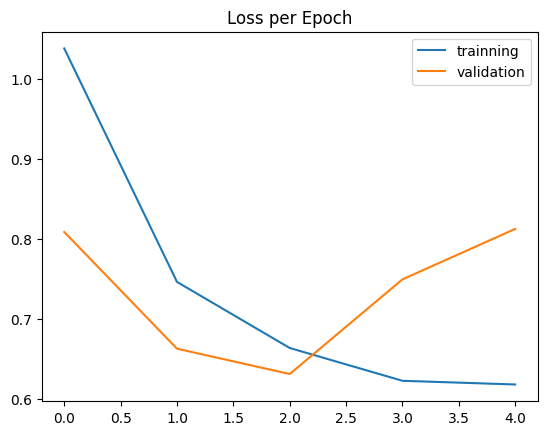

In [ ]:
plt.plot(history.history['loss'], label='trainning')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

In [ ]:
print('Test Accuracy = ', new_cnn_model.evaluate(test_X, test_Y, verbose=0)[1])

Test Accuracy =  0.8888888955116272


In [ ]:
Y_pred = new_cnn_model.predict(test_generator)
Y_pred

31/31 [==============================] - 186s 6s/step


array([[0.44326615, 0.4422858 , 0.39766872, ..., 0.4662859 , 0.40603733,
        0.45694155],
       [0.44326615, 0.4422858 , 0.39766872, ..., 0.4662859 , 0.40603733,
        0.45694155],
       [0.44326615, 0.4422858 , 0.39766872, ..., 0.4662859 , 0.40603733,
        0.45694155],
       ...,
       [0.44326615, 0.4422858 , 0.39766872, ..., 0.46628594, 0.40603733,
        0.45694155],
       [0.44326615, 0.4422858 , 0.39766872, ..., 0.46628594, 0.40603733,
        0.45694155],
       [0.44326615, 0.44228578, 0.39766872, ..., 0.46628594, 0.40603733,
        0.45694155]], dtype=float32)

In [ ]:
for c_label, p_count, t_count in zip(
    all_labels,
    100*np.mean(Y_pred,0),
    100*np.mean(test_Y, 0)
):
    print(c_label)
    print('Actual: %2.2f%%, Predicted: %2.2f%%' % (t_count, p_count))
    print()